## IMPORTANT NOTE

please use [THIS LINK](https://nbviewer.jupyter.org/github/Korf74/ADA/blob/master/03%20-%20Interactive%20Viz/Remi.ipynb) to see the notebook with the maps displayed.

# Question 1

In [1]:
import pandas as pd
import re
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

First We import json and folium, and we make sure we have the right version.

In [2]:
import json
import folium

folium.__version__ == '0.5.0'

True

The first step is to retrieve the data from eurostat. The format is *tsv* and it contains unemployment rates in the EU from 2007 to 2016. We'll only keep the 2016 data.

We delete unwanted rows (whole EU for example), and make the rates to be floats.

In [3]:
df = pd.read_csv('eurostat.tsv', sep='\t')
df.columns = ['Region', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016']
df = df[['Region', '2016']]
df['Region'] = df['Region'].apply(lambda x: x.split(',', 1)[0])
df.drop(df.tail(2).index, inplace=True)
df.drop(df.head(6).index, inplace=True)

df['2016'] = df['2016'].apply(lambda x: re.sub('[bui ]', '', x)).astype('float')
df['Region'] = df['Region'].replace('Germany (until 1990 former territory of the FRG)', 'Germany')
df

,Region,2016
6,Belgium,4.7
7,Bulgaria,4.5
8,Czech Republic,2.6
9,Denmark,4.3
10,Germany,2.9
11,Estonia,4.8
12,Ireland,5.1
13,Greece,14.1
14,Spain,12.8
15,France,6.1


In [4]:
df.describe()

,2016
count,31.000000
mean,5.364516
std,2.652112
min,2.500000
25%,3.650000
50%,4.800000
75%,6.150000
max,14.100000


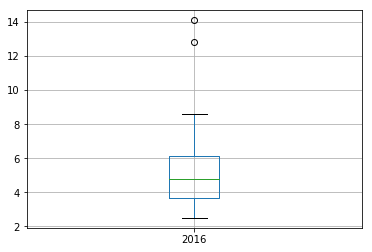

In [5]:
df.boxplot()

As you can see, unemployment rates range from 2.5 to 14.1% with a 5.36 mean and 4.8 median. The EU average is slightly above Switzerland's.

Note that there are two big outliers : Greece at 14.1% and Spain at 12.8%, thus we'll have to be careful about it, and we should now rely on the mean, rather on the median that is more robust to outliers.

We then create our map and get the topojson that was given.

In [6]:
m_eu = folium.Map([54, 15], tiles='cartodbpositron', zoom_start=4)

In [7]:
js = r'topojson/europe.topojson.json'
js_data = json.load(open(js))
js_data['objects']['europe']['geometries'][:3]

[{'arcs': [[[0, 1, 2]], [[3]], [[4]], [[5, 6, 7, 8, 9, 10], [11]]],
  'id': 'AZ',
  'properties': {'NAME': 'Azerbaijan'},
  'type': 'MultiPolygon'},
 {'arcs': [[12, 13, 14, 15, 16, 17, 18]],
  'id': 'AL',
  'properties': {'NAME': 'Albania'},
  'type': 'Polygon'},
 {'arcs': [[[-12]], [[19, -3, 20, 21, -7], [-5], [-4]]],
  'id': 'AM',
  'properties': {'NAME': 'Armenia'},
  'type': 'MultiPolygon'}]

Displayed above is a sample of json informations for each european country.

The next step is to get all country names and keep only those for which we have informations.

In [8]:
regions = df['Region'].tolist()
countries = pd.DataFrame(
    {'Region': 
     [x['properties']['NAME'] for x in js_data['objects']['europe']['geometries'] if x['properties']['NAME'] in regions]}
)
countries

,Region
0,Bulgaria
1,Cyprus
2,Denmark
3,Ireland
4,Estonia
5,Austria
6,Czech Republic
7,Finland
8,France
9,Germany


In [9]:
data_map = countries.merge(df, on='Region', how='outer')
data_map

,Region,2016
0,Bulgaria,4.5
1,Cyprus,8.6
2,Denmark,4.3
3,Ireland,5.1
4,Estonia,4.8
5,Austria,4.1
6,Czech Republic,2.6
7,Finland,5.8
8,France,6.1
9,Germany,2.9


In [10]:
eu = js_data['objects']['europe']['geometries']
regs = data_map['Region'].tolist()
new_eu = [x for x in eu if x['properties']['NAME'] in regs]
js_data['objects']['europe']['geometries'] = new_eu

We can now draw the map. By using a style function and the data manipulation above, we draw in grey countries for which we don't have data.

In [11]:
def color_country(name):
    if(name in regs):
        return '#996DAD'
    else:
        return '#727272'

In [12]:
folium.TopoJson(open(js), 'objects.europe',
               style_function=lambda feature: {
                'fillColor': color_country(feature['properties']['NAME']),
                'color': 'black',
                'weight': 2   
                }).add_to(m_eu)

In [13]:
m_eu

# The Choropleth Map

We can now draw our choropleth map above the topological one, which permits to keep track of countries without data.

Recall that there are two big outliers in the data. What we chose to do is to create 5 different classes, that roughly represent quantiles and outliers so that the choropleth map will show countries with similar unemployment rates in the same color.

We first draw the basic map for comparison.

In [14]:
m_eu.choropleth(geo_data=js_data, data=data_map,
         columns=['Region', '2016'],topojson = 'objects.europe',
         key_on='feature.properties.NAME',
         fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
         legend_name='unemployment rates for countries within Europe', highlight = True)

In [15]:
%%HTML
<iframe width=100% height=850 src="ex1_choropleth1.html"></iframe>

In [16]:
df.describe()

,2016
count,31.000000
mean,5.364516
std,2.652112
min,2.500000
25%,3.650000
50%,4.800000
75%,6.150000
max,14.100000


In [17]:
def assign_class(n):
    if n < 3.65:
        return 0
    elif n < 4.8:
        return 1
    elif n < 6.15:
        return 2
    elif n < 10:
        return 3
    else:
        return 4

In [18]:
data_map['2016'] = data_map['2016'].apply(assign_class)

In [19]:
m_eu.choropleth(geo_data=js_data, data=data_map,
         columns=['Region', '2016'],topojson = 'objects.europe',
         key_on='feature.properties.NAME',
         fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
         legend_name='similar unemployment rates for countries within Europe', highlight = True)

In [20]:
%%HTML
<iframe width=100% height=850 src="ex1_choropleth2.html"></iframe>

## Question 2 

In [21]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [22]:
import folium

We chose Luzern to be the center of our map

In [23]:
swiss_center = [46.915670, 8.413455]

We create the map centered in Luzern with a zoom start of 8 in order to maximize the size of Switzerland while displaying it entierly.

In [24]:
m_canton = folium.Map(location=swiss_center,zoom_start=8,tiles='cartodbpositron')

We load our two data files that we will use.
The first one is a TopoJson file that containt topoligical informations about the differents Cantons in order to color them differently in the following tasks.
The second one is an excel file that was generated and downloaded from the amstat website. We choose to import the following features for the month of September 2017 since it is the most recent report available:
 - The unemployement ration per Canton
 - The number of unemployed people per Canton
 - The number of jobseekers
 - The number of jobseekers not unemployed

In [25]:
topo_path = r'topojson/ch-cantons.topojson.json'
chomage_ratio_path = r'data/Taux_chomage_xl.xlsx'

cho_rat = pd.read_excel(chomage_ratio_path)
topo = json.load(open(topo_path))
cho_rat.head()

,Canton,Mois,Septembre 2017,Septembre 2017.1,Septembre 2017.2,Septembre 2017.3,Total,Total.1,Total.2,Total.3
0,NaN,Mesures,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
1,Zurich,NaN,3.3,27225,34156,6931,3.3,27225,34156,6931
2,Berne,NaN,2.4,13658,18385,4727,2.4,13658,18385,4727
3,Lucerne,NaN,1.7,3885,6756,2871,1.7,3885,6756,2871
4,Uri,NaN,0.6,112,257,145,0.6,112,257,145


Since we are using only one month, it doesn't make sense to keep the "Total" columns.

In [26]:
colums_to_keep = [col for col in cho_rat.columns if "Total" not in col]
cho_rat = cho_rat[colums_to_keep]

We replace the name of columns [1:] by the values of the first row.
We then drop the first row. We also drop the last raw that represents the total of each columns wich we don't need.

In [27]:
cho_rat.columns = [np.insert(cho_rat.loc[0].values[1:], [0], 'Cantons')]

cho_rat = cho_rat.drop([0])
cho_rat = cho_rat.drop([len(cho_rat)])

The 'Mesures' columns that contained NaN values is replaced by a 'Month' column with value "September 2017". This is just to keep all the information that was contained in the original data.

In [28]:
cho_rat = cho_rat.rename(columns = {'Mesures': 'Mois'})
cho_rat['Mois'] = 'Septembre 2017'

In [29]:
cho_rat.head()

,Cantons,Mois,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
1,Zurich,Septembre 2017,3.3,27225,34156,6931
2,Berne,Septembre 2017,2.4,13658,18385,4727
3,Lucerne,Septembre 2017,1.7,3885,6756,2871
4,Uri,Septembre 2017,0.6,112,257,145
5,Schwyz,Septembre 2017,1.7,1455,2229,774


We translate by hand the values of the columns for convinience of the peer reviewers

In [30]:
cho_rat = cho_rat.rename(columns = {'Mois': 'Month',
                                   'Taux de chômage': 'Unemployment rate',
                                   'Chômeurs inscrits': 'Registered unemployed',
                                   "Demandeurs d'emploi": "Job seekers",
                                   "Demandeurs d'emploi non chômeurs": 'Employed job seekers'})

We can now calculate the active population based on the Unemployement ration.
The unemployement ration is given by the number of unemployed persons divided by the active population multiplied by 100. Therefore the active population is given by $\frac{\text{Unemployed people}}{\text{Unemployement percentage}} * 100$

In [31]:
cho_rat['Active population'] = (cho_rat['Registered unemployed'].astype('float')*100/cho_rat['Unemployment rate'].astype('float')).astype('int')
cho_rat.head()

,Cantons,Month,Unemployment rate,Registered unemployed,Job seekers,Employed job seekers,Active population
1,Zurich,Septembre 2017,3.3,27225,34156,6931,825000
2,Berne,Septembre 2017,2.4,13658,18385,4727,569083
3,Lucerne,Septembre 2017,1.7,3885,6756,2871,228529
4,Uri,Septembre 2017,0.6,112,257,145,18666
5,Schwyz,Septembre 2017,1.7,1455,2229,774,85588


We get the Cantons ids from the TopoJson. We will need it for the drawing since the dataframe values for Cantons needs to match the Json values. We could have used the names if we had downloaded  the data in German, but we downloaded it in french therefore the names were differents.

In [32]:
canton_id = pd.DataFrame(topo['objects']['cantons']['geometries'])['id']

### Unemployement percentage:
This choropleth map represent the percentage of unemployed people wich means the number of unemployed people over the number of active people mulpiplied by hundred, as explained on the amstat website.
    [LINK](https://www.amstat.ch/v2/definition.jsp?lang=fr)

In [33]:
sumary_chom = cho_rat[['Cantons', 'Unemployment rate']]
sumary_chom['Unemployment rate'] = sumary_chom['Unemployment rate'].astype('float')
sumary_chom['Cantons'] = canton_id.values
m_canton.choropleth(geo_data=topo, data=sumary_chom,
             columns=['Cantons', 'Unemployment rate'],topojson = 'objects.cantons',
             key_on='feature.id',
             fill_color='YlOrBr',
             fill_opacity=0.7,
             line_opacity=0.4,
             legend_name='Unemployement percentage(%)',
             highlight = True)
#m_canton.save('Unemployed.html')
m_canton


/home/remi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/remi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [34]:
cho_rat.head()

,Cantons,Month,Unemployment rate,Registered unemployed,Job seekers,Employed job seekers,Active population
1,Zurich,Septembre 2017,3.3,27225,34156,6931,825000
2,Berne,Septembre 2017,2.4,13658,18385,4727,569083
3,Lucerne,Septembre 2017,1.7,3885,6756,2871,228529
4,Uri,Septembre 2017,0.6,112,257,145,18666
5,Schwyz,Septembre 2017,1.7,1455,2229,774,85588


### Jobseeker Percentage:
Contrary to what was explained on the readme of this homework, the unemployement rate doesn't include the jobseeker that have a job. Therefore we now plot the ratio $\frac{\text{Job seekers}}{\text{Active population}} * 100$

In [35]:
js_ratio = cho_rat.copy()
js_ratio['Jobseekers ratio'] = cho_rat['Job seekers'].values.astype('float')/cho_rat["Active population"].values.astype('float')*100
js_ratio['Cantons'] = canton_id.values
js_ratio = js_ratio[['Cantons', 'Jobseekers ratio']]
m_canton1 = folium.Map(location=swiss_center,zoom_start=8,tiles='cartodbpositron')
m_canton1.choropleth(geo_data=topo, data=js_ratio,
             columns=['Cantons', 'Jobseekers ratio'],topojson = 'objects.cantons',
             key_on='feature.id',
             fill_color='YlOrBr',
             fill_opacity=0.7,
             line_opacity=0.4,
             legend_name='Jobseekers percentage(%)',
             highlight = True)
#m_canton1.save('Jobseekers.html')
m_canton1

### Employed Jobseekers
Notice that the difference between the unemployed people and the jobseekers is exactly the number of jobseekers that are employed. Since this last value is smaller than the two others, it make more sense to plot it by itself.
Therefore we display the ratio $\frac{\text{Employed job seekers}}{\text{Active population}} * 100$

In [36]:
unstatisfied = cho_rat.copy()
unstatisfied['Employed jobseekers ratio'] = cho_rat['Employed job seekers'].values.astype('float')/cho_rat["Active population"].values.astype('float')*100
unstatisfied['Cantons'] = canton_id.values
unstatisfied = unstatisfied[['Cantons', 'Employed jobseekers ratio']]
m_canton2 = folium.Map(location=swiss_center,zoom_start=8,tiles='cartodbpositron')
m_canton2.choropleth(geo_data=topo, data=unstatisfied,
             columns=['Cantons', 'Employed jobseekers ratio'],topojson = 'objects.cantons',
             key_on='feature.id',
             fill_color='YlOrBr',
             fill_opacity=0.7,
             line_opacity=0.4,
             legend_name='Employed jobseekers (%)',
             highlight = True)
#m_canton2.save('Employed_jobseekers.html')
m_canton2

### Discussion
The last map shows more differences, at least we see that it's is not the same distibution as ot was for the unemployement ration.
Let's plot those two ratio side by side to see more easily the differences.

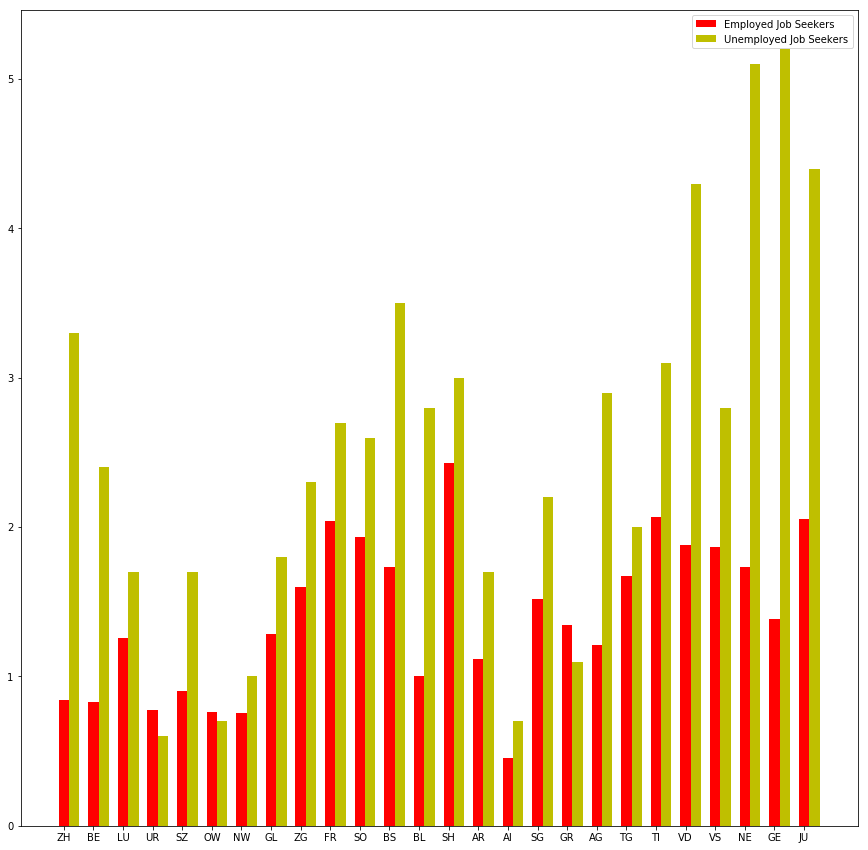

In [37]:
fig, ax = plt.subplots(figsize=(15,15))
ind = np.arange(len(unstatisfied))  
width = 0.35

rects1 = ax.bar(ind, unstatisfied['Employed jobseekers ratio'].values, width, color='r')
rects2 = ax.bar(ind + width, sumary_chom['Unemployment rate'].values, width, color='y')
ax.legend((rects1[0], rects2[0]), ('Employed Job Seekers', 'Unemployed Job Seekers'))
ax.set_xticklabels(unstatisfied.Cantons.values, minor=False)
ax.set_xticks(np.arange(len(unstatisfied)))

plt.show()

In general both ratio seems to be proportial per Cantons. However we can see different component for Cantons with high unemployement and also Cantons with low unemployements.
As we can see for Cantons with very low ratio of unemployements, the ratio difference is small(i.e UR,OW, NW, AI, GR), contrary to Cantons with high ration of unemployement.(i.e ZH, GE, NE).<br>
Therefore we can imagine a disire of changing of job in Cantons with high unemployement is more risky that is why we don't obeserve a similar proporting for employed job seekers. Whether in Cantons with low unemployement both values are so small that we can just say that the employement situation looks good in those region

# Question 3

The following section is separated in two parts. First, we extract and visualize in a map the Unemployement rate for swiss nationality holders and foreigners. The visualization is followed by textual analyses on the meaning of the statistics. The second part, categorize the unemployement rate to diffent age group and it follows an analyse.


### First Part

In [38]:
# Import the usefull libraries.
import pandas as pd
import numpy as np
import folium # to generate the map.
from folium import plugins
import json # manipulate json files.
import matplotlib # plot bar plots
import matplotlib.pyplot as plt

The unemployement rate is found in the officiel website of the confederation <a href="https://www.amstat.ch/v2/index.jsp" target="_blank"> amstat</a> . Using there extrating interface, we download a csv file which contains the unemployement rate for foreigners and swiss nationality holder per canton.

In [39]:
data_filename = r'data/unemployement_rate_foreign_modif.csv'
data = pd.read_csv(data_filename, skiprows = 2) # skip the first to lines.
data.tail()

,Canton,Nationalité,Mois,Septembre 2017,Septembre 2017.1,Septembre 2017.2,Septembre 2017.3,Total,Total.1,Total.2,Total.3
49,Genève,Etrangers,NaN,5.7,A,5'942,7'601,5.7,A,5'942,7'601
50,Genève,Suisses,NaN,4.8,A,6'292,7'896,4.8,A,6'292,7'896
51,Jura,Etrangers,NaN,9,C,505,729,9,C,505,729
52,Jura,Suisses,NaN,3.6,B,1'114,1'646,3.6,B,1'114,1'646
53,Total,NaN,NaN,3,A,133'169,193'624,3,A,133'169,193'624


As you can see, the row is not relevent as we want to show the pourcentage per canton, we keep the necesary columns ( Canton, Nationalité,Septembre 2017). Septembre 2017 respresent the unemployement rate.

In [40]:
# drop the unused column.
keep_index = ['Canton', 'Nationalité','Septembre 2017']
data_dropped =data[keep_index]
data_dropped = data_dropped.drop([0,53]) # the first line is also not relevent.because it is a line of separation.
data_dropped.head()

,Canton,Nationalité,Septembre 2017
1,Zurich,Etrangers,5.3
2,Zurich,Suisses,2.5
3,Berne,Etrangers,5.5
4,Berne,Suisses,1.8
5,Lucerne,Etrangers,3.9


The idea is two have 1 dataframe for each group, swiss nationality horlders and foreigners. Let's start with the Swiss.

In [41]:
swiss_data = data_dropped[data_dropped.Nationalité == 'Suisses'] ## filter by Swiss.
swiss_data = swiss_data.drop('Nationalité',axis=1)
swiss_data['Septembre 2017'] = swiss_data['Septembre 2017'].astype(float)
swiss_data.head()


,Canton,Septembre 2017
2,Zurich,2.5
4,Berne,1.8
6,Lucerne,1.3
8,Uri,0.4
10,Schwyz,1.2


We do the same with the foreigners.

In [42]:
foreign_data = data_dropped[data_dropped.Nationalité == 'Etrangers']
foreign_data = foreign_data.drop('Nationalité',axis=1)
foreign_data['Septembre 2017'] = foreign_data['Septembre 2017'].astype(float)
foreign_data.head()

,Canton,Septembre 2017
1,Zurich,5.3
3,Berne,5.5
5,Lucerne,3.9
7,Uri,2.1
9,Schwyz,3.4


To create the map, We need to attach each canton his percentage. By inspecting the json file ( `ch-cantons.topojson.json` ) we see in each canton entity, there is a `name` and `id` field. The id field represent the officiel abbreviation , BE for Berne for example. 

In order to link the percentage with the cantons, one idea is to link with the `name` field. This is a bad idea because they are not always the same. The right idea is to link with the `id`. Our Dataframe as no `id` field, therefore we will use the json to extract the id field and concatenate with our dataframe. Fortunaly, the order of the canton appearance in the id field and our dataframe is the same.

In [43]:
json_filename = r'topojson/ch-cantons.topojson.json' 
canton_data = json.load(open(json_filename))

id_canton = pd.DataFrame(canton_data['objects']['cantons']['geometries'])['id']
swiss_data = swiss_data.reset_index()
swiss_data = swiss_data.drop('index', axis =1)


foreign_data = foreign_data.reset_index()
foreign_data = foreign_data.drop('index', axis =1)



In [44]:
swiss_data = swiss_data.join(id_canton)
swiss_data.head()


,Canton,Septembre 2017,id
0,Zurich,2.5,ZH
1,Berne,1.8,BE
2,Lucerne,1.3,LU
3,Uri,0.4,UR
4,Schwyz,1.2,SZ


In [45]:
foreign_data = foreign_data.join(id_canton)
foreign_data.head()

,Canton,Septembre 2017,id
0,Zurich,5.3,ZH
1,Berne,5.5,BE
2,Lucerne,3.9,LU
3,Uri,2.1,UR
4,Schwyz,3.4,SZ


In [46]:
foreign_data = foreign_data[['id','Septembre 2017']] 
foreign_data
swiss_data = swiss_data[['id','Septembre 2017']] 

We have all we need to diplay the map. We create a function `build_map(data,column,title)` that diplay the map linked with the data. (see doc)

In [47]:
# This function return a folium map with the data linked to it.
# data: the data to attach
# column : the index of the column, first the id and the sequence is the percentage.
# title : The name of the map.
def build_map(data,column,title):
    m = folium.Map([46.8182,8.2275], tiles='cartodbpositron', zoom_start = 7)
   
    
    m.choropleth(geo_data=canton_data, data=data,
             columns=column,topojson = 'objects.cantons',
             key_on='feature.id',
             fill_color='YlOrBr', fill_opacity=0.7, line_opacity=0.2,
             legend_name=title, highlight = True)
    return m

In [48]:
m_swiss = build_map(swiss_data, ['id', 'Septembre 2017'], 'Unemployement rate for swiss nationality holders (%)')
m_swiss

In [49]:
m_foreign = build_map(foreign_data, ['id', 'Septembre 2017'], 'Unemployement rate for foreigners (%)')
m_foreign

Now that we showed the unemployement rate and swiss nationality holder and foreigners, lets see the differences between them. We first merge them together in order to take the difference.

In [50]:

merge_data = swiss_data.merge(foreign_data,on='id')
merge_data.columns = ['id','swiss','foreign']
merge_data.head()


,id,swiss,foreign
0,ZH,2.5,5.3
1,BE,1.8,5.5
2,LU,1.3,3.9
3,UR,0.4,2.1
4,SZ,1.2,3.4


We take the difference.

In [51]:
merge_data['diff'] = merge_data['foreign']/merge_data['swiss']
merge_data.head()

,id,swiss,foreign,diff
0,ZH,2.5,5.3,2.120000
1,BE,1.8,5.5,3.055556
2,LU,1.3,3.9,3.000000
3,UR,0.4,2.1,5.250000
4,SZ,1.2,3.4,2.833333


Display the map using the function created above.

In [52]:
m_diff = build_map(merge_data, ['id','diff'], 'Ratio Difference between the swiss and foreigners.')
m_diff


Above, the ratio between the umployement rate between the swiss nationality and foreigners, we see that the center of the country (<a href="https://en.wikipedia.org/wiki/Canton_of_Waldst%C3%A4tten" target="_blank">Waldstätten</a>) has a large disparency. It is because, this cantons have conservative tendency, therefore it is more difficult to find a job for foreigners.

### Second Part

Ad the first part, we will extract the data from the confederation website and make a bar plot where the x axes represent the cantons and the y the percentage of unemployement.

In [53]:
data = pd.read_csv('./data/unemployement_rateAge.csv')
data.head()

,Canton,Age Class,Unemployement rate
0,Zurich,15-24 ans,3.7
1,Zurich,25-49 ans,3.4
2,Zurich,50 ans et plus,2.9
3,Berne,15-24 ans,2.8
4,Berne,25-49 ans,2.5


 We are able to plot the bar plot.

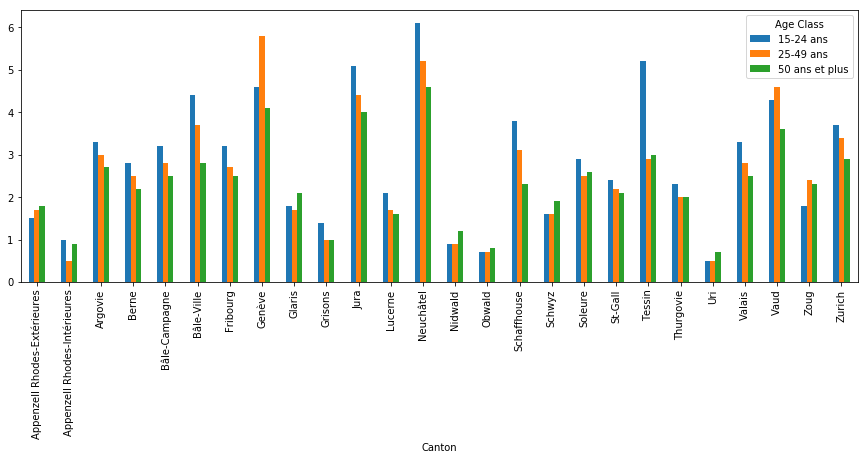

In [54]:
pivot = data.pivot(index = 'Canton', columns='Age Class', values='Unemployement rate')
pivot.plot.bar(figsize = (15,5))
plt.show()



Some values are interessing to note. Geneva has a high percentage of unemployement rate for age class 25-49 and Ticino has a high percentage for age group between 15-24. They both are border cantons. In the border, there is a high traffic of people that comes from behond the border to work, because the salary is high. For the employee it is cheaper therefore the work market is saturated.
